In [1]:
# Install required packages
!pip install tensorflow opencv-python-headless pandas numpy tqdm scikit-learn

In [2]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from google.colab import drive
import sys
import os

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [4]:
import cv2

In [5]:
# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:

# Add Google Drive folder to Python path
project_path = "/content/drive/MyDrive/Capstone DL project"  # Adjust to your folder
sys.path.append(project_path)
sys.path.append(os.path.join(project_path, 'models'))


# Loading and preproccessing

In [7]:
!pip install opencv-python-headless pandas numpy tqdm

In [8]:
# Import necessary libraries
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm  # Ensure tqdm is imported
from google.colab import drive
import os

In [9]:
# Define paths
dataset_path = '/content/drive/MyDrive/Capstone DL project/Facial Expression Recognition Challenge Dataset/fer2013/fer2013/fer2013.csv'  # Adjust path as needed
output_dir = '/content/drive/MyDrive/Capstone DL project/Facial Expression Recognition Challenge Dataset/fer2013/fer2013/fer2013_processed'
image_size = (48, 48)


In [10]:

def load_fer2013():
    """Load and process the FER2013 dataset from CSV."""
    try:
        # Check if dataset file exists
        if not os.path.exists(dataset_path):
            raise FileNotFoundError(f"Dataset file not found at {dataset_path}")

        # Read CSV
        print("Loading dataset...")
        data = pd.read_csv(dataset_path)

        # Extract pixels and convert to images
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in tqdm(pixels, desc="Processing images"):
            # Convert pixel string to array
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            # Resize and convert to float32
            face = cv2.resize(face.astype('uint8'), image_size)
            faces.append(face.astype('float32'))

        # Convert to numpy array and add channel dimension
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)

        # Convert emotions to one-hot encoded matrix
        emotions = pd.get_dummies(data['emotion']).to_numpy()

        return faces, emotions

    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        return None, None


In [11]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

In [12]:
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)
    img_input = Input(input_shape)

    # Base Convolutional Block
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    x = SeparableConv2D(16, (3, 3), padding='same', depthwise_regularizer=regularization, pointwise_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same', depthwise_regularizer=regularization, pointwise_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Add()([x, residual])

    # Module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    x = SeparableConv2D(32, (3, 3), padding='same', depthwise_regularizer=regularization, pointwise_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same', depthwise_regularizer=regularization, pointwise_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Add()([x, residual])

    # Module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    x = SeparableConv2D(64, (3, 3), padding='same', depthwise_regularizer=regularization, pointwise_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same', depthwise_regularizer=regularization, pointwise_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Add()([x, residual])

    # Module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    x = SeparableConv2D(128, (3, 3), padding='same', depthwise_regularizer=regularization, pointwise_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', depthwise_regularizer=regularization, pointwise_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Add()([x, residual])

    # Output
    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
    return model

In [13]:
# Parameters
batch_size = 32
num_epochs = 500
input_shape = (48, 48, 1)
validation_split = 0.2
verbose = 1
num_classes = 7
patience = 50

In [14]:
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [15]:
from tensorflow.keras.optimizers import SGD

In [16]:

# Model parameters/compilation
try:
    model = mini_XCEPTION(input_shape, num_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
except Exception as e:
    print(f"Error building model: {str(e)}")
    raise

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 46, 46, 8) │         72 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 46, 46, 8) │         32 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 46, 46, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 44, 44, 8) │        576 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44, 8) │         32 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 44, 44, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 44, 44,    │        200 │ activation_1[0][… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 44, 44,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 44, 44,    │        400 │ activation_2[0][… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 22, 22,    │        128 │ activation_1[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 22, 22,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 22, 22,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 22, 22,    │        656 │ add[0][0]         │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 58,423 (228.21 KB)

 Trainable params: 56,951 (222.46 KB)

 Non-trainable params: 1,472 (5.75 KB)

In [17]:
# Define the Learning Rate Scheduler
from tensorflow.keras.callbacks import LearningRateScheduler

In [18]:
# Callbacks
log_file_path = os.path.join(project_path, '_emotion_training.log')
csv_logger = CSVLogger(log_file_path, append=False)

best_model_path = os.path.join(project_path, 'best_mini_XCEPTION.keras')
model_checkpoint = ModelCheckpoint(
    best_model_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)


early_stop = EarlyStopping(monitor='val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=int(patience/4), verbose=1)



def lr_scheduler(epoch, lr):
    if epoch % 20 == 0 and epoch > 0:
        new_lr = lr * 0.5
        print(f"Reducing learning rate to {new_lr} at epoch {epoch}")
        return new_lr
    return lr

# Create the scheduler callback
# lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Add the scheduler to the callbacks list
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

In [19]:
# Loading dataset
print("Attempting to load dataset...")
faces, emotions = load_fer2013()

if faces is not None and emotions is not None:
    print(f"Loaded {len(faces)} images with shape {faces.shape}")
    print(f"Loaded emotions with shape {emotions.shape}")

    # Preprocess images
    print("Preprocessing images...")
    faces = preprocess_input(faces, v2=True)
    print("Images preprocessed.")

    # The rest of your data processing and splitting logic should go here
    # For example, splitting into train/test, etc.

else:
    # This block will be executed if load_fer2013 returned None, None
    # The specific error from load_fer2013's except block should have been printed already
    raise ValueError("Failed to load dataset. Check the error message from load_fer2013.")

# After successful loading and preprocessing, you would continue with:
# num_samples, num_classes = emotions.shape # Re-define num_classes based on loaded data
# print(f"Loaded {num_samples} samples with {num_classes} classes")
# xtrain, xtest, ytrain, ytest = train_test_split(faces, emotions, test_size=validation_split, shuffle=True)
# print("Dataset split into training and testing sets.")

Attempting to load dataset...
Loading dataset...


Processing images: 100%|██████████| 35887/35887 [00:21<00:00, 1674.15it/s]


Loaded 35887 images with shape (35887, 48, 48, 1)
Loaded emotions with shape (35887, 7)
Preprocessing images...
Images preprocessed.


In [20]:
# Split dataset
xtrain, xtest, ytrain, ytest = train_test_split(faces, emotions, test_size=validation_split, shuffle=True)

In [21]:
from sklearn.utils.class_weight import compute_class_weight

In [22]:
# Train model
try:
    history = model.fit(
        data_generator.flow(xtrain, ytrain, batch_size=batch_size),
        steps_per_epoch=len(xtrain) // batch_size,
        epochs=num_epochs,
        verbose=verbose,
        callbacks=callbacks,
        validation_data=(xtest, ytest)
    )
    print("Training completed successfully")
except Exception as e:
    print(f"Error during training: {str(e)}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/500
895/897 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2782 - loss: 4.0590
Epoch 1: val_loss improved from inf to 2.00259, saving model to /content/drive/MyDrive/Capstone DL project/best_mini_XCEPTION.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.2784 - loss: 4.0554 - val_accuracy: 0.3879 - val_loss: 2.0026 - learning_rate: 0.0010
Epoch 2/500
  1/897 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.5625 - loss: 1.5780

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 2.00259
897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5625 - loss: 1.5780 - val_accuracy: 0.3833 - val_loss: 2.0090 - learning_rate: 0.0010
Epoch 3/500
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4243 - loss: 1.7876
Epoch 3: val_loss improved from 2.00259 to 1.64319, saving model to /content/drive/MyDrive/Capstone DL project/best_mini_XCEPTION.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 57s 21ms/step - accuracy: 0.4243 - loss: 1.7876 - val_accuracy: 0.4301 - val_loss: 1.6432 - learning_rate: 0.0010
Epoch 4/500
  1/897 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5312 - loss: 1.4298
Epoch 4: val_loss improved from 1.64319 to 1.63530, saving model to /content/drive/MyDrive/Capstone DL project/best_mini_XCEPTION.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5312 - loss: 1.4298 - val_accuracy: 0.4324 - val_loss: 1.6353 - learning_rate: 0.0010
Epoch 5/500
896/897 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4556 - los

In [23]:
project_path = "/content/drive/MyDrive/Capstone DL project" # Re-define or ensure accessible
if project_path not in sys.path:
  sys.path.append(project_path)

In [24]:
# Define the path to save the model on Google Drive
model_save_path = os.path.join(project_path, 'final_mini_XCEPTION_model.keras')

# Save the model
try:
    model.save(model_save_path)
    print(f"Model saved successfully to {model_save_path}")
except Exception as e:
    print(f"Error saving model: {str(e)}")

Model saved successfully to /content/drive/MyDrive/Capstone DL project/final_mini_XCEPTION_model_v2.keras


In [25]:
# Load the saved model
try:
    loaded_model = tf.keras.models.load_model(model_save_path)
    print(f"Model loaded successfully from {model_save_path}")
except Exception as e:
    print(f"Error loading model: {str(e)}")

Model loaded successfully from /content/drive/MyDrive/Capstone DL project/final_mini_XCEPTION_model_v2.keras


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Evaluate the model on the test set
try:
    # Get predictions
    y_pred = model.predict(xtest)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
    y_true_classes = np.argmax(ytest, axis=1)   # Convert one-hot encoded test labels to class labels

    # Calculate metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    # Print metrics
    print("\nModel Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")

    # Optional: Detailed classification report per class
    print("\nDetailed Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=[f"Class {i}" for i in range(num_classes)]))

except Exception as e:
    print(f"Error evaluating model: {str(e)}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

Model Evaluation Metrics:
Accuracy: 0.6032
Precision (weighted): 0.6013
Recall (weighted): 0.6032
F1-Score (weighted): 0.5957

Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       0.50      0.55      0.52       995
     Class 1       0.52      0.13      0.21       109
     Class 2       0.49      0.32      0.38      1062
     Class 3       0.82      0.85      0.84      1789
     Class 4       0.49      0.46      0.47      1188
     Class 5       0.73      0.72      0.72       815
     Class 6       0.49      0.64      0.56      1220

    accuracy                           0.60      7178
   macro avg       0.58      0.52      0.53      7178
weighted avg       0.60      0.60      0.60      7178



In [28]:
project_path = "/content/drive/MyDrive/Capstone DL project"
output_dir = os.path.join(project_path, "visualizations")
os.makedirs(output_dir, exist_ok=True)
#             (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
num_classes = len(class_names)

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Evaluate the model on the test set
try:
    # Get predictions
    y_pred = model.predict(xtest)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
    y_true_classes = np.argmax(ytest, axis=1)   # Convert one-hot encoded test labels to class labels

    # Calculate metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    # Print metrics
    print("\nModel Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")

    # Optional: Detailed classification report per class
    print("\nDetailed Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=[f"Class {i}" for i in range(num_classes)]))

except Exception as e:
    print(f"Error evaluating model: {str(e)}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Model Evaluation Metrics:
Accuracy: 0.6032
Precision (weighted): 0.6013
Recall (weighted): 0.6032
F1-Score (weighted): 0.5957

Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       0.50      0.55      0.52       995
     Class 1       0.52      0.13      0.21       109
     Class 2       0.49      0.32      0.38      1062
     Class 3       0.82      0.85      0.84      1789
     Class 4       0.49      0.46      0.47      1188
     Class 5       0.73      0.72      0.72       815
     Class 6       0.49      0.64      0.56      1220

    accuracy                           0.60      7178
   macro avg       0.58      0.52      0.53      7178
weighted avg       0.60      0.60      0.60      7178



In [30]:
def plot_training_history(history):
    """Plot training and validation accuracy/loss over epochs."""
    try:
        history_dict = history.history
        epochs = range(1, len(history_dict['accuracy']) + 1)

        plt.figure(figsize=(12, 5))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history_dict['accuracy'], 'b-', label='Training Accuracy')
        plt.plot(epochs, history_dict['val_accuracy'], 'orange', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history_dict['loss'], 'b-', label='Training Loss')
        plt.plot(epochs, history_dict['val_loss'], 'orange', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        save_path = os.path.join(output_dir, 'training_history.png')
        plt.savefig(save_path)
        plt.show()
        plt.close()
        print(f"Training history plot saved to {save_path}")
    except Exception as e:
        print(f"Error plotting training history: {str(e)}")

def plot_confusion_matrix(model, xtest, ytest):
    """Plot confusion matrix as a heatmap."""
    try:
        y_pred = model.predict(xtest)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(ytest, axis=1)
        cm = confusion_matrix(y_true_classes, y_pred_classes)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()

        save_path = os.path.join(output_dir, 'confusion_matrix.png')
        plt.savefig(save_path)
        plt.show()
        plt.close()
        print(f"Confusion matrix saved to {save_path}")
    except Exception as e:
        print(f"Error plotting confusion matrix: {str(e)}")

def plot_per_class_metrics(model, xtest, ytest):
    """Plot bar chart of precision, recall, and F1-score per class."""
    try:
        y_pred = model.predict(xtest)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(ytest, axis=1)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes)

        x = np.arange(len(class_names))
        width = 0.25

        plt.figure(figsize=(12, 6))
        plt.bar(x - width, precision, width, label='Precision', color='skyblue')
        plt.bar(x, recall, width, label='Recall', color='lightgreen')
        plt.bar(x + width, f1, width, label='F1-Score', color='salmon')
        plt.xticks(x, class_names, rotation=45)
        plt.title('Per-Class Precision, Recall, and F1-Score')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True, axis='y')
        plt.tight_layout()

        save_path = os.path.join(output_dir, 'per_class_metrics.png')
        plt.savefig(save_path)
        plt.show()
        plt.close()
        print(f"Per-class metrics plot saved to {save_path}")
    except Exception as e:
        print(f"Error plotting per-class metrics: {str(e)}")

def plot_sample_predictions(model, xtest, ytest, num_samples=9):
    """Plot a grid of sample test images with true and predicted labels."""
    try:
        indices = np.random.choice(len(xtest), num_samples, replace=False)
        sample_images = xtest[indices]
        sample_true = np.argmax(ytest[indices], axis=1)
        sample_pred = np.argmax(model.predict(sample_images), axis=1)

        plt.figure(figsize=(10, 10))
        for i in range(num_samples):
            plt.subplot(3, 3, i + 1)
            img = sample_images[i].reshape(48, 48)  # Reshape for display
            plt.imshow(img, cmap='gray')
            plt.title(f"True: {class_names[sample_true[i]]}\nPred: {class_names[sample_pred[i]]}")
            plt.axis('off')
        plt.tight_layout()

        save_path = os.path.join(output_dir, 'sample_predictions.png')
        plt.savefig(save_path)
        plt.show()
        plt.close()
        print(f"Sample predictions plot saved to {save_path}")
    except Exception as e:
        print(f"Error plotting sample predictions: {str(e)}")


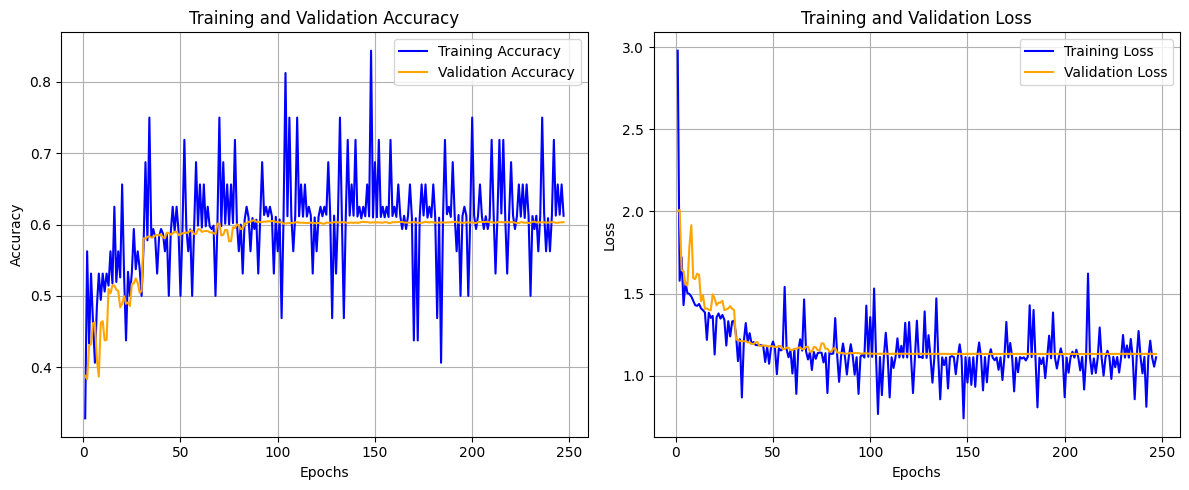

Training history plot saved to /content/drive/MyDrive/Capstone DL project/visualizations/training_history.png
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


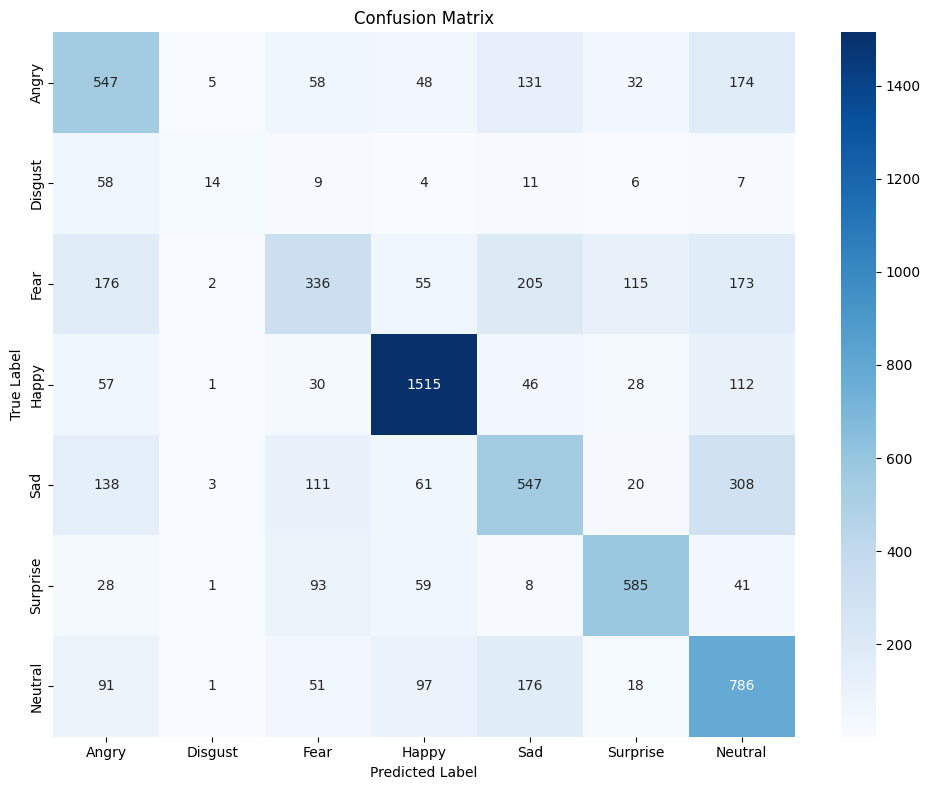

Confusion matrix saved to /content/drive/MyDrive/Capstone DL project/visualizations/confusion_matrix.png
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


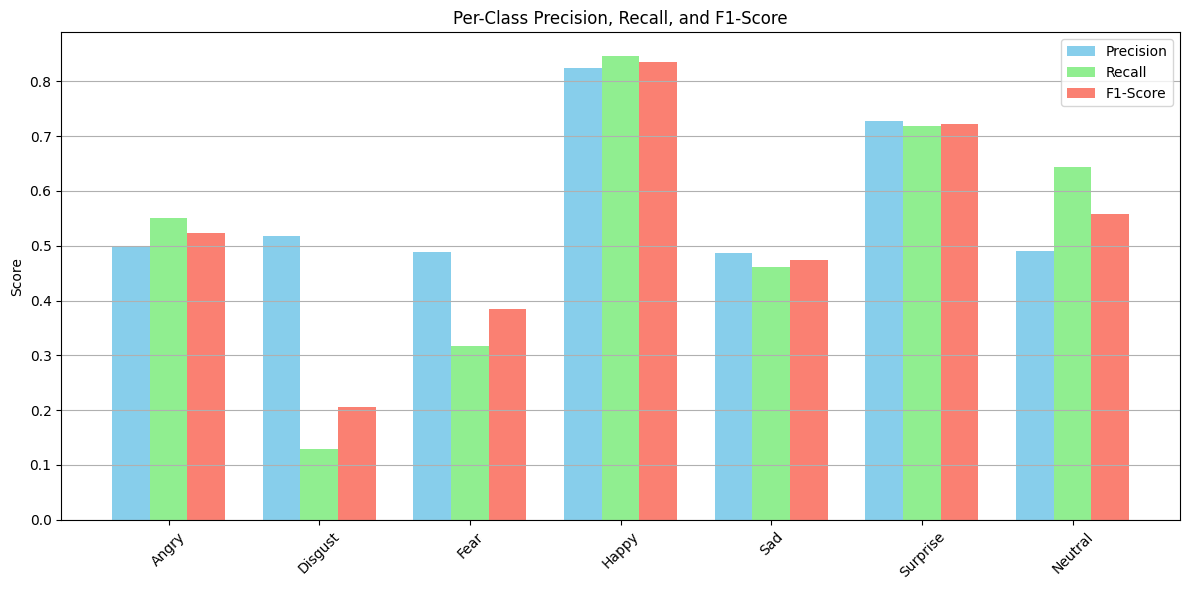

Per-class metrics plot saved to /content/drive/MyDrive/Capstone DL project/visualizations/per_class_metrics.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


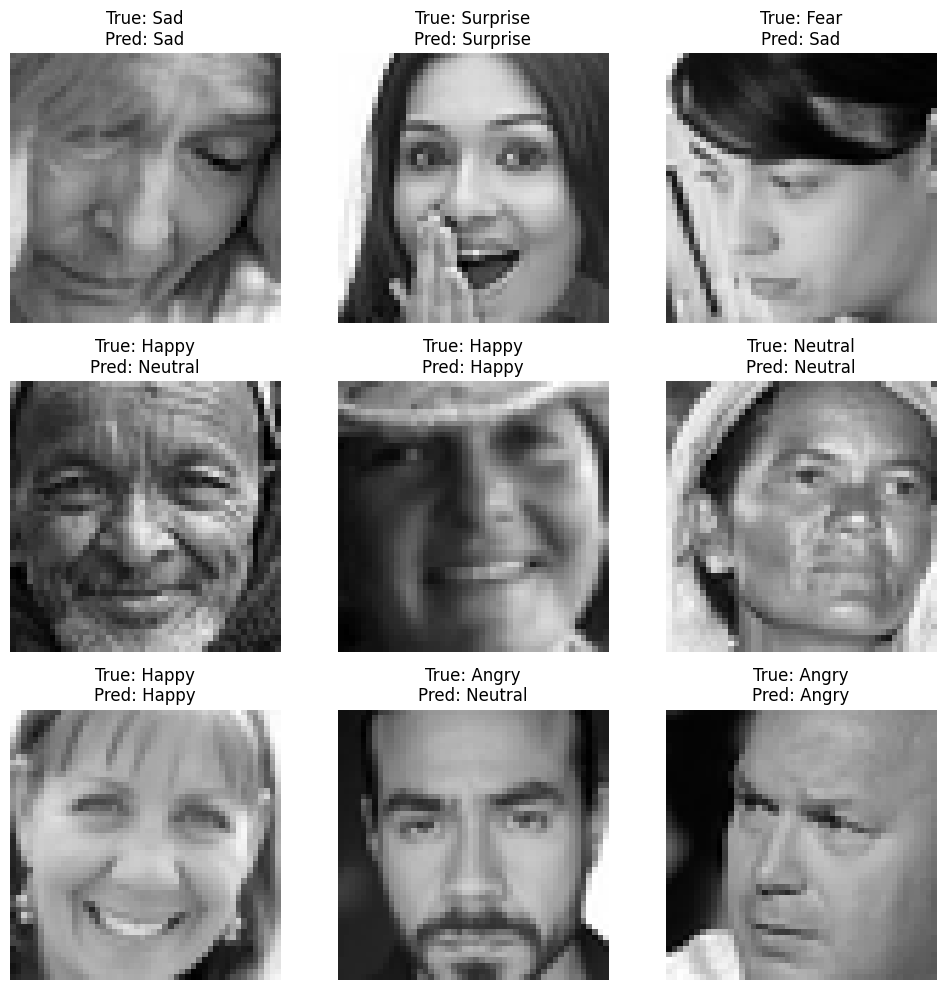

Sample predictions plot saved to /content/drive/MyDrive/Capstone DL project/visualizations/sample_predictions.png


In [31]:
# Call the plotting functions
try:
    plot_training_history(history)  # history from model.fit()
    plot_confusion_matrix(model, xtest, ytest)
    plot_per_class_metrics(model, xtest, ytest)
    plot_sample_predictions(model, xtest, ytest)
except NameError as e:
    print(f"Error: Required variables (history, model, xtest, ytest) not found. Ensure training is complete: {str(e)}")